In [21]:
a = (1, 2, 3, 4)
print(type(a))

<class 'tuple'>


In [22]:
import os
import yaml

obstacles_path = "/home/federico/isaaclab/IsaacLab/source/isaaclab_tasks/isaaclab_tasks/direct/jetbot/obs_cfg.yaml"

with open(obstacles_path, 'r') as f:
    obstacles_cfg = yaml.safe_load(f)
obstacles = obstacles_cfg['maze']['walls']

print('obstacles:', obstacles)
print(type(obstacles))

obstacles: [{'start': [-2.0, -0.6], 'end': [-2.0, 0.6]}, {'start': [2.0, -0.6], 'end': [2.0, 0.6]}, {'start': [-0.6, 2.0], 'end': [0.6, 2.0]}, {'start': [-0.6, -2.0], 'end': [0.6, -2.0]}]
<class 'list'>


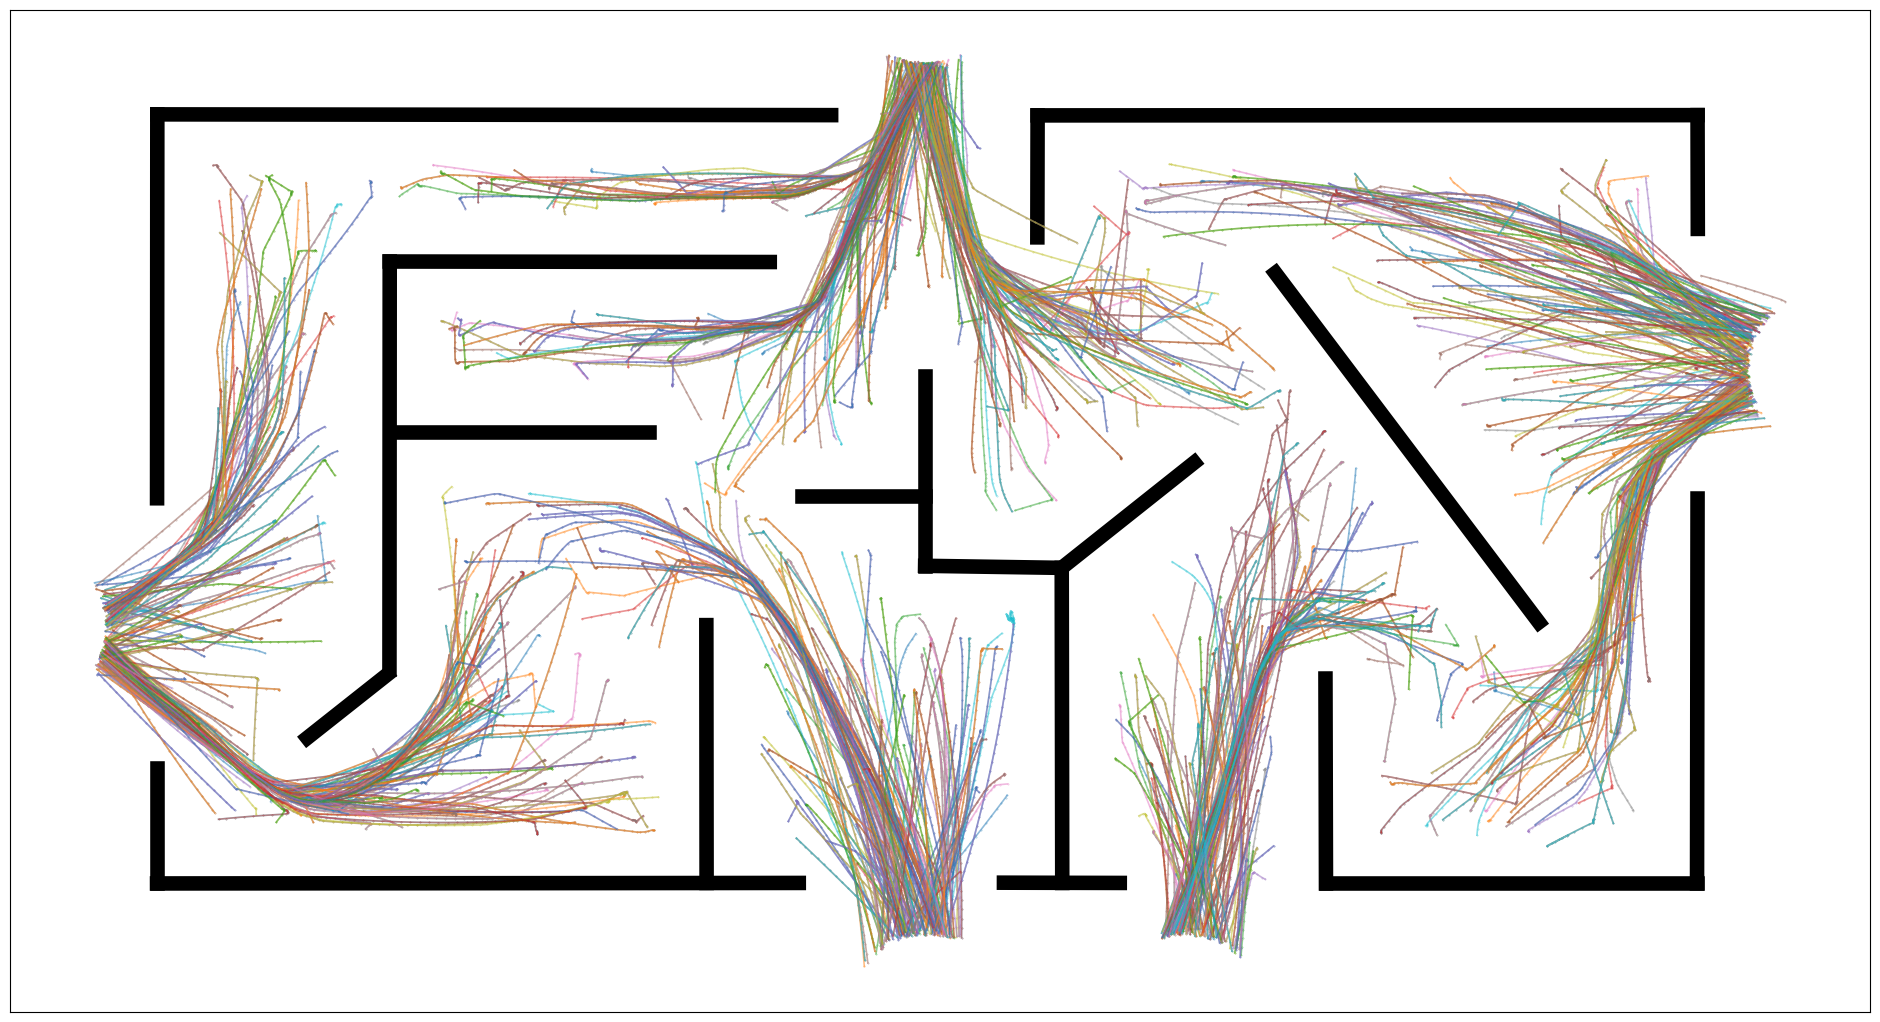

In [30]:
import yaml
import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
import re

def load_maze_config(yaml_file):
    with open(yaml_file, "r") as f:
        config = yaml.safe_load(f)
    return config["maze"]["walls"]

def plot_maze(walls):
    plt.figure(figsize=(24, 24))
    for wall in walls:
        start = wall["start"]
        end = wall["end"]
        # Plot the wall as a black line
        plt.plot([start[1], end[1]], [start[0], end[0]], "k-", linewidth=10.5)
    plot_trajectories("/home/federico/isaaclab/IsaacLab/trajectory.csv", plt)
    plt.grid(False) # Remove the grid lines
    plt.xticks([]) # Remove x-axis tick marks
    plt.yticks([]) # Remove y-axis tick marks
    plt.xlabel('') # Remove x-axis label
    plt.ylabel('') # Remove y-axis label
    # plt.title("Maze Map with Trajectories") # Title remains, as requested
    plt.gca().set_aspect("equal", adjustable='box')

def plot_trajectories(trajectories_path, plt):
    point_pattern = re.compile(r'\[\s*(-?\d+\.?\d*)\s*,\s*(-?\d+\.?\d*)\s*\]')

    # open traj csv
    try:
        with open(trajectories_path, 'r') as f:
            reader = csv.reader(f) # Use csv.reader to handle quoted fields correctly
            
            for index, row_fields in enumerate(reader):
                # row_fields will be a list of strings, e.g., ['[-1.087..., -0.337...]', '[-1.088..., -0.337...]', ...]
                
                # Concatenate all fields in the row into a single string.
                # This reconstructs the continuous trajectory string that our regex expects.
                full_trajectory_str = ",".join(row_fields) 
                
                x_coords = []
                y_coords = []

                # Find all [x,y] pairs using the compiled regex on the full string
                matches = point_pattern.findall(full_trajectory_str)

                for match in matches:
                    try:
                        # Convert the captured string parts to floats
                        x_coords.append(float(match[0]))
                        y_coords.append(float(match[1]))
                    except ValueError as e:
                        print(f"Warning: Could not parse coordinates '{match}' in row {index}. Error: {e}")
                        continue # Skip to the next match if parsing fails

                # Plot the trajectory if valid coordinates were found
                if x_coords and y_coords:
                    plt.plot(y_coords, x_coords, marker='.', linestyle='-', markersize=0.6, linewidth=1.2, alpha=0.5)
    except FileNotFoundError:
        print(f"Error: The file '{trajectories_path}' was not found. Please check the path.")
    except Exception as e:
        print(f"An unexpected error occurred while reading or plotting trajectories: {e}")




if __name__ == "__main__":
    # Path to your YAML config file
    yaml_file = "/home/federico/isaaclab/IsaacLab/source/isaaclab_tasks/isaaclab_tasks/direct/jetbot/maze_cfg.yaml"  
    walls = load_maze_config(yaml_file)
    plot_maze(walls)

In [ ]:
import math
import os
import yaml
import matplotlib.pyplot as plt
import numpy as np

class Maze:
    def __init__(self, cfg_path="/home/federico/isaaclab/IsaacLab/source/isaaclab_tasks/isaaclab_tasks/direct/jetbot/maze_cfg.yaml"):
        self.walls = []
        self.config_path = cfg_path

        with open(self.config_path, "r") as f:
            maze_config = yaml.safe_load(f)
        self.walls = maze_config["maze"]["walls"]

    def spawn_maze(self, width=0.5, height=0.5, walls=None):
        if walls is None:
            walls = self.walls

        self.width = width
        self.height = height

        self.walls_start = np.array([wall["start"] for wall in self.walls], dtype=np.float32)  # shape: [num_walls, 2]
        self.walls_end   = np.array([wall["end"] for wall in self.walls], dtype=np.float32)    # shape: [num_walls, 2]

    def plot_maze(self, robot_positions=None):
        """
        Plot the maze in 2D using matplotlib and plot robot positions.
        robot_positions: List of robot positions to plot (e.g., [(x1, y1), (x2, y2), ...])
        """
        # Plot walls as thick lines
        for wall in self.walls:
            start = np.array(wall["start"])
            end = np.array(wall["end"])
            plt.plot([start[0], end[0]], [start[1], end[1]], color='black', linewidth=1)  # Multiply by 10 to make it thicker

        # Plot robots
        if robot_positions is not None:
            robot_positions = np.array(robot_positions)
            plt.scatter(robot_positions[:, 0], robot_positions[:, 1], color='red', s=50, label='Robots')

        # Set labels and show plot
        plt.xlabel('X position')
        plt.ylabel('Y position')
        plt.title('Maze with Robot Positions')
        plt.legend()
        plt.grid(True)
        plt.axis('equal')
        plt.show()

    def distance_from_line(self, point, start, end):
        """
        Compute perpendicular distance from point to the line defined by start and end.
        """
        p = np.array(point)
        s = np.array(start)
        e = np.array(end)

        if np.allclose(s, e):
            return np.linalg.norm(p - s)
        return np.abs(np.cross(e-s, s-p)) / np.linalg.norm(e-s)

    def check_collision_ang_np(self, pos, yaw):
        """
        Compute the distances from each robot (pos) to each wall and the angle differences
        between the robot's heading (yaw) and the direction to the three closest points on the walls.
        
        Args:
            pos (np.ndarray): Robot positions, shape [num_envs, 2].
            yaw (np.ndarray): Robot yaw angles in radians, shape [num_envs,] or [num_envs,1].
            
        Returns:
            tuple:
              - smallest3 (np.ndarray): Array of shape [num_envs, 3] containing the three smallest distances.
              - angle_diffs (np.ndarray): Array of shape [num_envs, 3] with the angle differences (in radians) 
                                          between the robot’s yaw and the direction to the closest points.
        """
        # Ensure yaw is 1D: shape (num_envs,)
        yaw = np.squeeze(yaw)  # now shape: (num_envs,)
        
        # Unpack wall endpoints as numpy arrays
        A = self.walls_start  # shape: [num_walls, 2]
        B = self.walls_end    # shape: [num_walls, 2]
        
        # Compute wall center-line vectors V = B - A and their squared norms.
        V = B - A                           # [num_walls, 2]
        norm_sq = np.sum(V**2, axis=1)        # [num_walls,]
        norm_sq = np.where(norm_sq == 0, 1e-6, norm_sq)  # avoid division by zero
        
        num_envs = pos.shape[0]
        num_walls = A.shape[0]
        
        # Expand dimensions to compute pairwise differences:
        pos_exp = pos[:, np.newaxis, :]      # [num_envs, 1, 2]
        A_exp = A[np.newaxis, :, :]          # [1, num_walls, 2]
        V_exp = V[np.newaxis, :, :]          # [1, num_walls, 2]
        
        # Compute projection parameter t for each robot-wall pair:
        # t = ((P - A) dot V) / ||V||^2
        vec = pos_exp - A_exp               # [num_envs, num_walls, 2]
        dot = np.sum(vec * V_exp, axis=2)     # [num_envs, num_walls]
        t = dot / norm_sq[np.newaxis, :]      # [num_envs, num_walls]
        
        # Compute projection point on the infinite line: P_proj = A + t*V
        p_proj = A_exp + t[..., np.newaxis] * V_exp  # [num_envs, num_walls, 2]
        
        # Compute perpendicular distance to the infinite line
        d_perp = np.linalg.norm(pos_exp - p_proj, axis=2)  # [num_envs, num_walls]
        
        # --- Case 1: Projection falls on the segment (0 <= t <= 1) ---
        mask_inside = (t >= 0.0) & (t <= 1.0)   # [num_envs, num_walls]
        d_on_segment = np.maximum(d_perp - self.width/2.0, 0.0)  # [num_envs, num_walls]
        
        # --- Case 2: Projection falls outside the segment ---
        # For t < 0, the closest endpoint is A; for t > 1, it's B.
        # Compute distance from p_proj to A and B.
        d_ep_A = np.linalg.norm(p_proj - A_exp, axis=2)  # [num_envs, num_walls]
        d_ep_B = np.linalg.norm(p_proj - B[np.newaxis, :, :], axis=2)  # [num_envs, num_walls]
        d_ep = np.where(t < 0, d_ep_A, d_ep_B)            # [num_envs, num_walls]
        
        # For outside cases, decide:
        # If d_perp < width/2, robot is "beside" the wall, so use d_ep.
        # Else, robot is near a corner; compute corner distance:
        corner_distance = np.sqrt(d_ep**2 + (d_perp - self.width/2.0)**2)
        d_outside = np.where(d_perp < self.width/2.0, d_ep, corner_distance)
        
        # Combine: for each pair, if projection is inside, use d_on_segment; else use d_outside.
        final_dists = np.where(mask_inside, d_on_segment, d_outside)  # [num_envs, num_walls]
        
        # --- Select the 3 closest walls for each robot ---
        sorted_indices = np.argsort(final_dists, axis=1)  # [num_envs, num_walls]
        sorted_dists = np.sort(final_dists, axis=1)         # [num_envs, num_walls]
        smallest3 = sorted_dists[:, :3]                     # [num_envs, 3]
        top3_indices = sorted_indices[:, :3]                # [num_envs, 3]
        
        # --- Compute angle differences ---
        # For each robot, we need the corresponding projection point for the 3 closest walls.
        p_proj_closest = np.empty((num_envs, 3, 2))  # to store [num_envs, 3, 2]
        for i in range(num_envs):
            p_proj_closest[i] = p_proj[i, top3_indices[i], :]  # [3,2]
            
        # Vectors from robot position to each of these projection points:
        vectors_to_obs = p_proj_closest - pos[:, np.newaxis, :]  # [num_envs, 3, 2]
        # Compute angle of each vector
        obs_angles = np.arctan2(vectors_to_obs[:, :, 1], vectors_to_obs[:, :, 0])  # [num_envs, 3]
        
        # Compute angle difference: subtract robot yaw and wrap to (-pi, pi]
        # Note: yaw is [num_envs] → expand to [num_envs, 3]
        yaw_exp = np.expand_dims(yaw.squeeze(), axis=1)  # [num_envs, 1]
        angle_diffs = obs_angles - yaw_exp              # [num_envs, 3]
        angle_diffs = (angle_diffs + np.pi) % (2*np.pi) - np.pi
        
        return smallest3, angle_diffs



    def move_walls(self, percent):
        new_walls = []
        for wall in self.walls:
            start = np.array(wall["start"])
            end = np.array(wall["end"])
            dx = end[0] - start[0]
            dy = end[1] - start[1]
            new_start = [start[0] + dx * percent, start[1] + dy * percent]
            new_end = [end[0] + dx * percent, end[1] + dy * percent]
            new_walls.append({"start": new_start, "end": new_end})
        self.walls = new_walls  # Update the maze with the moved walls


In [ ]:
def compute_cost(
    cost_obstacle: float,
    min_dist: float,
    dist_to_obs: np.ndarray,
):
    cost_obstacles = np.where(dist_to_obs <= min_dist, cost_obstacle*(1 - dist_to_obs/min_dist), 0.0).sum(axis=1)
    return cost_obstacles

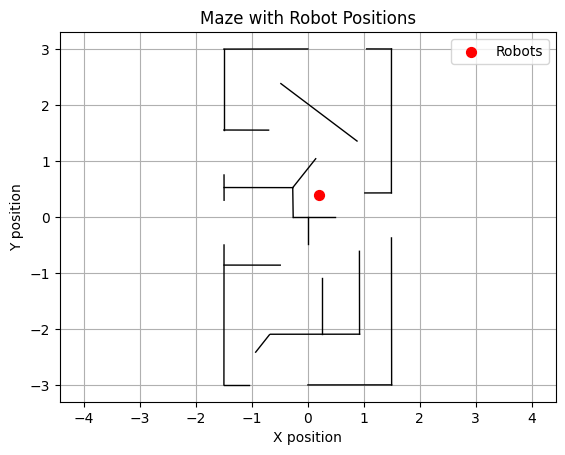

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
maze = Maze("/home/federico/isaaclab/IsaacLab/source/isaaclab_tasks/isaaclab_tasks/direct/jetbot/maze_cfg.yaml")

# Define some robot positions
robot_positions = [(0.2, 0.4)]

maze.spawn_maze()

# Plot the maze with robots
maze.plot_maze(robot_positions)

# Compute distances from the robots to walls
distances, ang = maze.check_collision_ang_np(robot_positions, np.array([0.0]))

cost = compute_cost(1.0, 0.1 + 0.12/2, distances)

print("Distances: ", distances)
print("Cost: ", cost)
print("Min dist: ", 0.1 + 0.12/2)

In [ ]:

    def check_collision(self, pos):
        """
        Compute the distances from each robot (given by their positions pos)
        to each wall defined by its start and end points.
        """
        walls_start = np.array(self.walls_start)  # shape: [num_walls, 2]
        walls_end = np.array(self.walls_end)      # shape: [num_walls, 2]
        
        # Compute wall direction vectors and their squared lengths
        wall_dirs = walls_end - walls_start            # shape: [num_walls, 2]
        norm_wall_dirs_sq = (wall_dirs ** 2).sum(axis=1)  # shape: [num_walls]
        norm_wall_dirs_sq = np.where(norm_wall_dirs_sq == 0, 1e-6, norm_wall_dirs_sq)  # Avoid division by zero
        
        # Reshape norm_wall_dirs_sq to make it broadcastable with the dot product
        norm_wall_dirs_sq = norm_wall_dirs_sq[None, :]  # shape: [1, num_walls]
        
        # Compute vector from wall start to each robot position
        pos_exp = np.array(pos)[:, None, :]              # shape: [num_robots, 1, 2]
        walls_start_exp = walls_start[None, :, :]        # shape: [1, num_walls, 2]
        wall_dirs_exp = wall_dirs[None, :, :]            # shape: [1, num_walls, 2]
        walls_end_exp = walls_end[None, :, :]            # shape: [1, num_walls, 2]

        # Compute the projection parameter t for each robot-wall pair:
        vec = pos_exp - walls_start_exp          # shape: [num_robots, num_walls, 2]
        dot = np.sum(vec * wall_dirs_exp, axis=2)  # shape: [num_robots, num_walls]
        t = dot / norm_wall_dirs_sq              # shape: [num_robots, num_walls]
        
        # Compute the projection point on the infinite line: P_proj = A + t*(B-A)
        p_proj = walls_start_exp + t[..., None] * wall_dirs_exp  # shape: [num_robots, num_walls, 2]

        # Compute perpendicular distance (d_perp) to the infinite line
        d_perp = np.linalg.norm(pos_exp - p_proj, axis=2)           # shape: [num_robots, num_walls]

        # --- Case 1: When projection falls on the segment (0 <= t <= 1) ---
        mask_inside = (t >= 0.0) & (t <= 1.0)  # shape: [num_robots, num_walls]
        d_on_segment = np.maximum(d_perp - self.width / 2.0, 0.0)  # adjusted distance when on segment

        # --- Case 2: When projection falls outside the segment (t < 0 or t > 1) ---
        mask_outside = ~mask_inside

        # For outside cases, determine the closest endpoint.
        d_ep_A = np.linalg.norm(p_proj - walls_start_exp, axis=2)  # distance from projection to start, shape: [num_robots, num_walls]
        d_ep_B = np.linalg.norm(p_proj - walls_end_exp, axis=2)    # distance from projection to end, shape: [num_robots, num_walls]
        
        # Ensure correct shapes for broadcasting:
        d_ep_A = np.expand_dims(d_ep_A, axis=0)  # shape: [1, num_robots, num_walls]
        d_ep_B = np.expand_dims(d_ep_B, axis=0)  # shape: [1, num_robots, num_walls]
        
        d_ep = np.where(t < 0, d_ep_A, d_ep_B)  # shape: [num_robots, num_walls]

        # Now, for outside cases, further decide:
        corner_distance = np.sqrt(d_ep**2 + (d_perp - self.width / 2.0)**2)
        d_outside = np.where(d_perp < self.width / 2.0, d_ep, corner_distance)

        # For outside, use d_outside; for inside, use d_on_segment.
        final_dists = np.where(mask_inside, d_on_segment, d_outside)  # shape: [num_robots, num_walls]

        # Remove the extra dimension at index 0 (if it exists)
        final_dists = np.squeeze(final_dists, axis=0)  # shape: [num_robots, num_walls]

        # Sort the distances along axis 1 (for each robot)
        sorted_dists = np.sort(final_dists, axis=1)  # shape: [num_robots, num_walls]

        # Select the smallest 3 distances for each robot
        smallest3 = sorted_dists[:, :3]  # shape: [num_robots, 3]

        return smallest3

In [ ]:
    def check_collision_ang_np(self, pos, yaw):
        """
        Compute the distances from each robot (pos) to each wall and the angle differences
        between the robot's heading (yaw) and the direction to the three closest points on the walls.
        
        Args:
            pos (np.ndarray): Robot positions, shape [num_envs, 2].
            yaw (np.ndarray): Robot yaw angles in radians, shape [num_envs,] or [num_envs,1].
            
        Returns:
            tuple:
              - smallest3 (np.ndarray): Array of shape [num_envs, 3] containing the three smallest distances.
              - angle_diffs (np.ndarray): Array of shape [num_envs, 3] with the angle differences (in radians) 
                                          between the robot’s yaw and the direction to the closest points.
        """
        # Ensure yaw is 1D: shape (num_envs,)
        yaw = np.squeeze(yaw)  # now shape: (num_envs,)
        
        # Unpack wall endpoints as numpy arrays
        A = self.walls_start  # shape: [num_walls, 2]
        B = self.walls_end    # shape: [num_walls, 2]
        
        # Compute wall center-line vectors V = B - A and their squared norms.
        V = B - A                           # [num_walls, 2]
        norm_sq = np.sum(V**2, axis=1)        # [num_walls,]
        norm_sq = np.where(norm_sq == 0, 1e-6, norm_sq)  # avoid division by zero
        
        num_envs = pos.shape[0]
        num_walls = A.shape[0]
        
        # Expand dimensions to compute pairwise differences:
        pos_exp = pos[:, np.newaxis, :]      # [num_envs, 1, 2]
        A_exp = A[np.newaxis, :, :]          # [1, num_walls, 2]
        V_exp = V[np.newaxis, :, :]          # [1, num_walls, 2]
        
        # Compute projection parameter t for each robot-wall pair:
        # t = ((P - A) dot V) / ||V||^2
        vec = pos_exp - A_exp               # [num_envs, num_walls, 2]
        dot = np.sum(vec * V_exp, axis=2)     # [num_envs, num_walls]
        t = dot / norm_sq[np.newaxis, :]      # [num_envs, num_walls]
        
        # Compute projection point on the infinite line: P_proj = A + t*V
        p_proj = A_exp + t[..., np.newaxis] * V_exp  # [num_envs, num_walls, 2]
        
        # Compute perpendicular distance to the infinite line
        d_perp = np.linalg.norm(pos_exp - p_proj, axis=2)  # [num_envs, num_walls]
        
        # --- Case 1: Projection falls on the segment (0 <= t <= 1) ---
        mask_inside = (t >= 0.0) & (t <= 1.0)   # [num_envs, num_walls]
        d_on_segment = np.maximum(d_perp - self.width/2.0, 0.0)  # [num_envs, num_walls]
        
        # --- Case 2: Projection falls outside the segment ---
        # For t < 0, the closest endpoint is A; for t > 1, it's B.
        # Compute distance from p_proj to A and B.
        d_ep_A = np.linalg.norm(p_proj - A_exp, axis=2)  # [num_envs, num_walls]
        d_ep_B = np.linalg.norm(p_proj - B[np.newaxis, :, :], axis=2)  # [num_envs, num_walls]
        d_ep = np.where(t < 0, d_ep_A, d_ep_B)            # [num_envs, num_walls]
        
        # For outside cases, decide:
        # If d_perp < width/2, robot is "beside" the wall, so use d_ep.
        # Else, robot is near a corner; compute corner distance:
        corner_distance = np.sqrt(d_ep**2 + (d_perp - self.width/2.0)**2)
        d_outside = np.where(d_perp < self.width/2.0, d_ep, corner_distance)
        
        # Combine: for each pair, if projection is inside, use d_on_segment; else use d_outside.
        final_dists = np.where(mask_inside, d_on_segment, d_outside)  # [num_envs, num_walls]
        
        # --- Select the 3 closest walls for each robot ---
        sorted_indices = np.argsort(final_dists, axis=1)  # [num_envs, num_walls]
        sorted_dists = np.sort(final_dists, axis=1)         # [num_envs, num_walls]
        smallest3 = sorted_dists[:, :3]                     # [num_envs, 3]
        top3_indices = sorted_indices[:, :3]                # [num_envs, 3]
        
        # --- Compute angle differences ---
        # For each robot, we need the corresponding projection point for the 3 closest walls.
        p_proj_closest = np.empty((num_envs, 3, 2))  # to store [num_envs, 3, 2]
        for i in range(num_envs):
            p_proj_closest[i] = p_proj[i, top3_indices[i], :]  # [3,2]
            
        # Vectors from robot position to each of these projection points:
        vectors_to_obs = p_proj_closest - pos[:, np.newaxis, :]  # [num_envs, 3, 2]
        # Compute angle of each vector
        obs_angles = np.arctan2(vectors_to_obs[:, :, 1], vectors_to_obs[:, :, 0])  # [num_envs, 3]
        
        # Compute angle difference: subtract robot yaw and wrap to (-pi, pi]
        # Note: yaw is [num_envs] → expand to [num_envs, 3]
        yaw_exp = np.expand_dims(yaw.squeeze(), axis=1)  # [num_envs, 1]
        angle_diffs = obs_angles - yaw_exp              # [num_envs, 3]
        angle_diffs = (angle_diffs + np.pi) % (2*np.pi) - np.pi
        
        return smallest3, angle_diffs